# Analyse ERA5 demand for NEM

In [69]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_WEEKEND = True

In [7]:
REMOVE_XMAS = True

In [8]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [9]:
MASK_NAME = "pop_dens_mask"

In [10]:
TIME_COLUMNS = []

In [11]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2019

In [12]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [13]:
N_FEATURES = "parsimonious"

In [14]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load demand and climate data

In [16]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH
)

In [32]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    # ds = ds.expand_dims({"region": [r]})
    pred_ds[r] = ds

### Compare statistics of train (2010-2019) vs test (1959-2009)

In [143]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    da = da / 1000
    
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [144]:
def plot_hist(ax, histograms, labels, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    for hist, label, color in zip(histograms, labels, colors):
        hist.plot(ax=ax, color=color, label=label)
    ax.set_ylabel("Density [-]")
    ax.set_xlabel("Demand [GWh / day")
    # ax.legend()

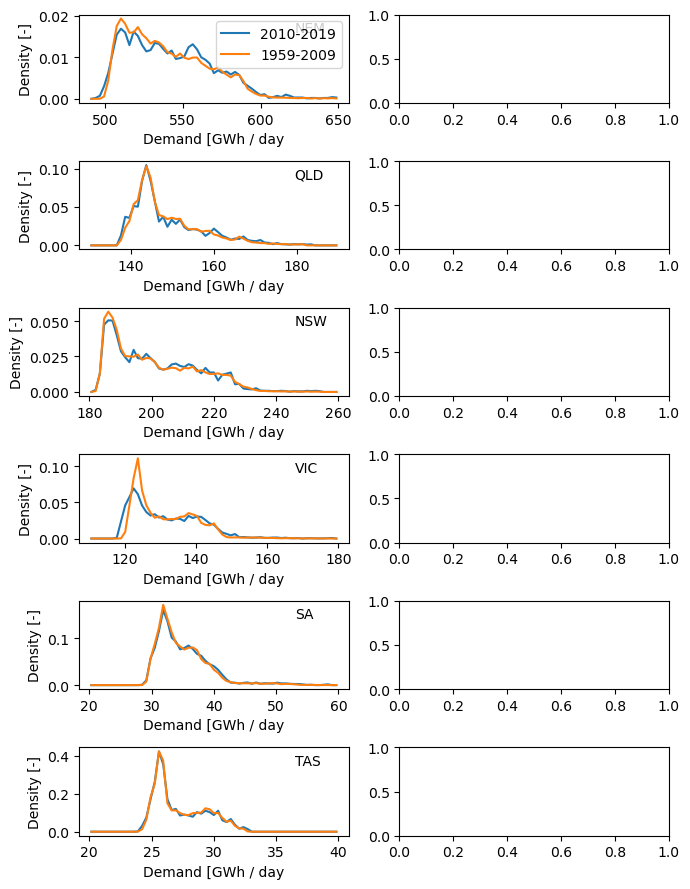

In [145]:
fig, ax = plt.subplots(6, 2, figsize=(7,9))

for i, r in enumerate(regions):
    for j, var in enumerate(["demand"]):
        hists = [
            get_hist(pred_ds[r][var].sel(time=slice("2010", "2019"))),
            get_hist(pred_ds[r][var].sel(time=slice("1959", "2009")))
        ]
        plot_hist(ax[i,j], hists, ["2010-2019", "1959-2009"])     
        
        ax[i,j].text(0.8, 0.8, r, transform=ax[i,j].transAxes)
        if i == 0:
            ax[i,j].legend()
        
plt.tight_layout()

In [89]:
da

<xarray.Dataset>
Dimensions:   (time: 3652)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
Data variables: (12/14)
    t2m       (time) float64 294.9 293.8 292.3 293.9 ... 297.2 298.5 298.6 294.7
    t2m3      (time) float64 296.8 295.4 293.7 293.3 ... 296.1 297.5 298.1 297.2
    cdd       (time) float64 0.3068 0.5373 0.2864 0.1159 ... 1.805 1.645 0.8637
    hdd       (time) float64 0.21 0.9327 1.186 ... -0.01192 -0.01567 0.94
    cdd4      (time) float64 0.9502 0.9831 0.5616 0.3116 ... 0.9801 1.301 1.302
    q         (time) float64 13.03 11.67 10.59 10.5 ... 9.858 10.32 9.718 8.823
    ...        ...
    t2min     (time) float64 291.5 290.2 289.1 289.1 ... 291.5 292.9 291.3 289.2
    t2m4      (time) float64 296.3 296.1 294.6 293.7 ... 295.9 296.7 297.7 297.2
    msdwswrf  (time) float64 182.8 234.4 227.1 278.0 ... 310.6 344.0 328.0 328.2
    w10       (time) float64 2.851 3.421 2.973 2.582 ... 2.375 2.031 3.099 2.699
    mtpr      (time) float64 7.961e-05 4.94e-05 6.647e-05 ... 1.16e-05 3.003e-06
    demand    (time) float64 5.606e+05 5.436e+05 ... 6.153e+05 5.747e+05

In [56]:
t = pred_ds[r]["demand"].sel(time=slice("1959", "2009")).quantile(0.999)

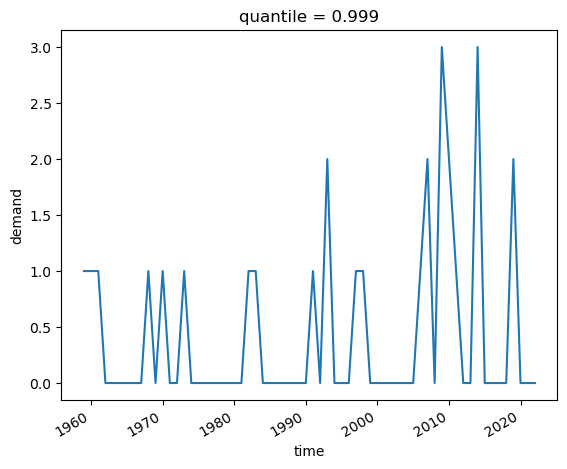

In [57]:
pred_ds[r].where(pred_ds[r]["demand"] > t)["demand"].resample(time="1YS").count().plot()

In [44]:
1 - 1 / (365*3)

0.9990867579908675